In [46]:
# @title
import pandas as pd
from scipy import stats
import numpy as np
import math

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from itertools import product
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.transforms
from torchvision.transforms import ToTensor
from torchvision.ops import MLP
from torch import optim

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

from IPython.display import clear_output

!pip install optuna
import optuna as opt

In [47]:
train_df = pd.read_csv('database/train.csv', index_col=0)
test_df = pd.read_csv('database/test.csv', index_col=0)
train_df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


# Train Validation Split

In [48]:
original_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

In [49]:
train_df, validation_df = train_test_split(original_df,test_size= 0.25, stratify=original_df['satisfaction'])

print('original_df: ',len(original_df))
print('train_df size: ', len(train_df), "| validation_df size:", len(validation_df))
print(f'train_df: {len(train_df)/len(original_df)}%', f"| validation_df: {len(validation_df)/len(original_df)}%",)

original_df:  103904
train_df size:  77928 | validation_df size: 25976
train_df: 0.75% | validation_df: 0.25%


# Outliers

<Axes: >

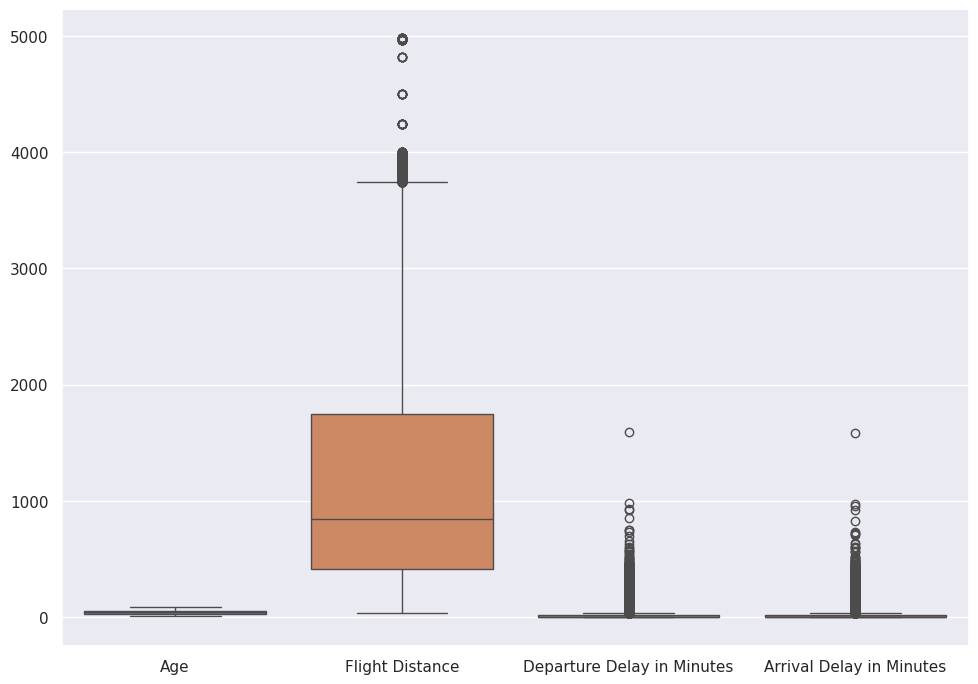

In [50]:
train_df.reset_index(drop=True, inplace=True)

cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

sns.boxplot(data=train_df[cols])

Original DataFrame Shape: (77928, 23)
DataFrame Shape after Removing Outliers: (76180, 23)
Columns with z-score > 3:  ['Age', 'Flight Distance', 'Departure Delay in Minutes']


<Axes: >

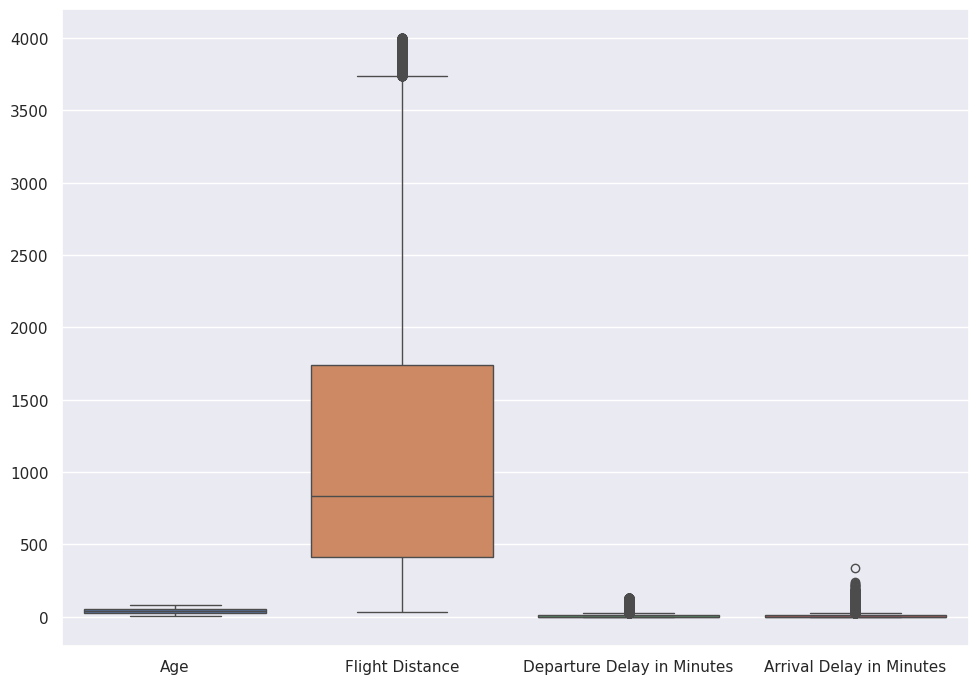

In [51]:
print("Original DataFrame Shape:", train_df.shape)
z_score_col = []
for cl in cols:
    z = np.abs(stats.zscore(train_df[cl]))
    outlier_set = (np.where(z > 3)[0])
    train_df = train_df.drop(index=outlier_set)
    train_df.reset_index(drop=True, inplace=True)
    if len(outlier_set > 0):
        z_score_col.append(cl)


print("DataFrame Shape after Removing Outliers:", train_df.shape)
print('Columns with z-score > 3: ', z_score_col)

sns.boxplot(data=train_df[cols])

# Enconding

## Class Variable

In [52]:
classes_dict = {
    'neutral or dissatisfied': 0,
    'satisfied': 1
}
def ord_encode(x):
    return classes_dict[x]

dec_class = 'satisfaction'
print('Before Encoding: ', train_df[dec_class].values)
train_df[dec_class] = train_df[dec_class].map(ord_encode)
validation_df[dec_class] = validation_df[dec_class].map(ord_encode)
print('After Encoding: ', train_df[dec_class].values)


Before Encoding:  ['neutral or dissatisfied' 'satisfied' 'satisfied' ...
 'neutral or dissatisfied' 'neutral or dissatisfied'
 'neutral or dissatisfied']
After Encoding:  [0 1 1 ... 0 0 0]


## One Hot Enconding

In [53]:
one_hot_encoder_vars = ['Type of Travel', 'Gender', 'Customer Type']
validation_df = pd.get_dummies(validation_df, columns=one_hot_encoder_vars, drop_first=True)
train_df = pd.get_dummies(train_df, columns=one_hot_encoder_vars, drop_first=True)
train_df[['Type of Travel_Personal Travel', 'Gender_Male',  'Customer Type_disloyal Customer']]

,Type of Travel_Personal Travel,Gender_Male,Customer Type_disloyal Customer
0,True,False,False
1,False,False,False
2,False,False,False
3,False,True,False
4,False,False,False
...,...,...,...
76175,False,False,False
76176,True,False,False
76177,True,False,False
76178,False,True,True


## Ordinal Enconding

In [54]:
classes_dict = {
    'Eco': 0,
    'Eco Plus': 1,
    'Business': 2
}
def ord_encode(x):
    return classes_dict[x]

ordinal_encoder_vars = ['Class']
print('Before Encoding: ', train_df[ordinal_encoder_vars].values)
train_df[ordinal_encoder_vars] = train_df[ordinal_encoder_vars].applymap(ord_encode)
validation_df[ordinal_encoder_vars] = validation_df[ordinal_encoder_vars].applymap(ord_encode)
print('After Encoding: ', train_df[ordinal_encoder_vars].values)

Before Encoding:  [['Eco']
 ['Business']
 ['Business']
 ...
 ['Business']
 ['Eco']
 ['Eco']]
After Encoding:  [[0]
 [2]
 [2]
 ...
 [2]
 [0]
 [0]]


# Correlation

## Continuous Variables

Needs to be done before Binning

<Axes: >

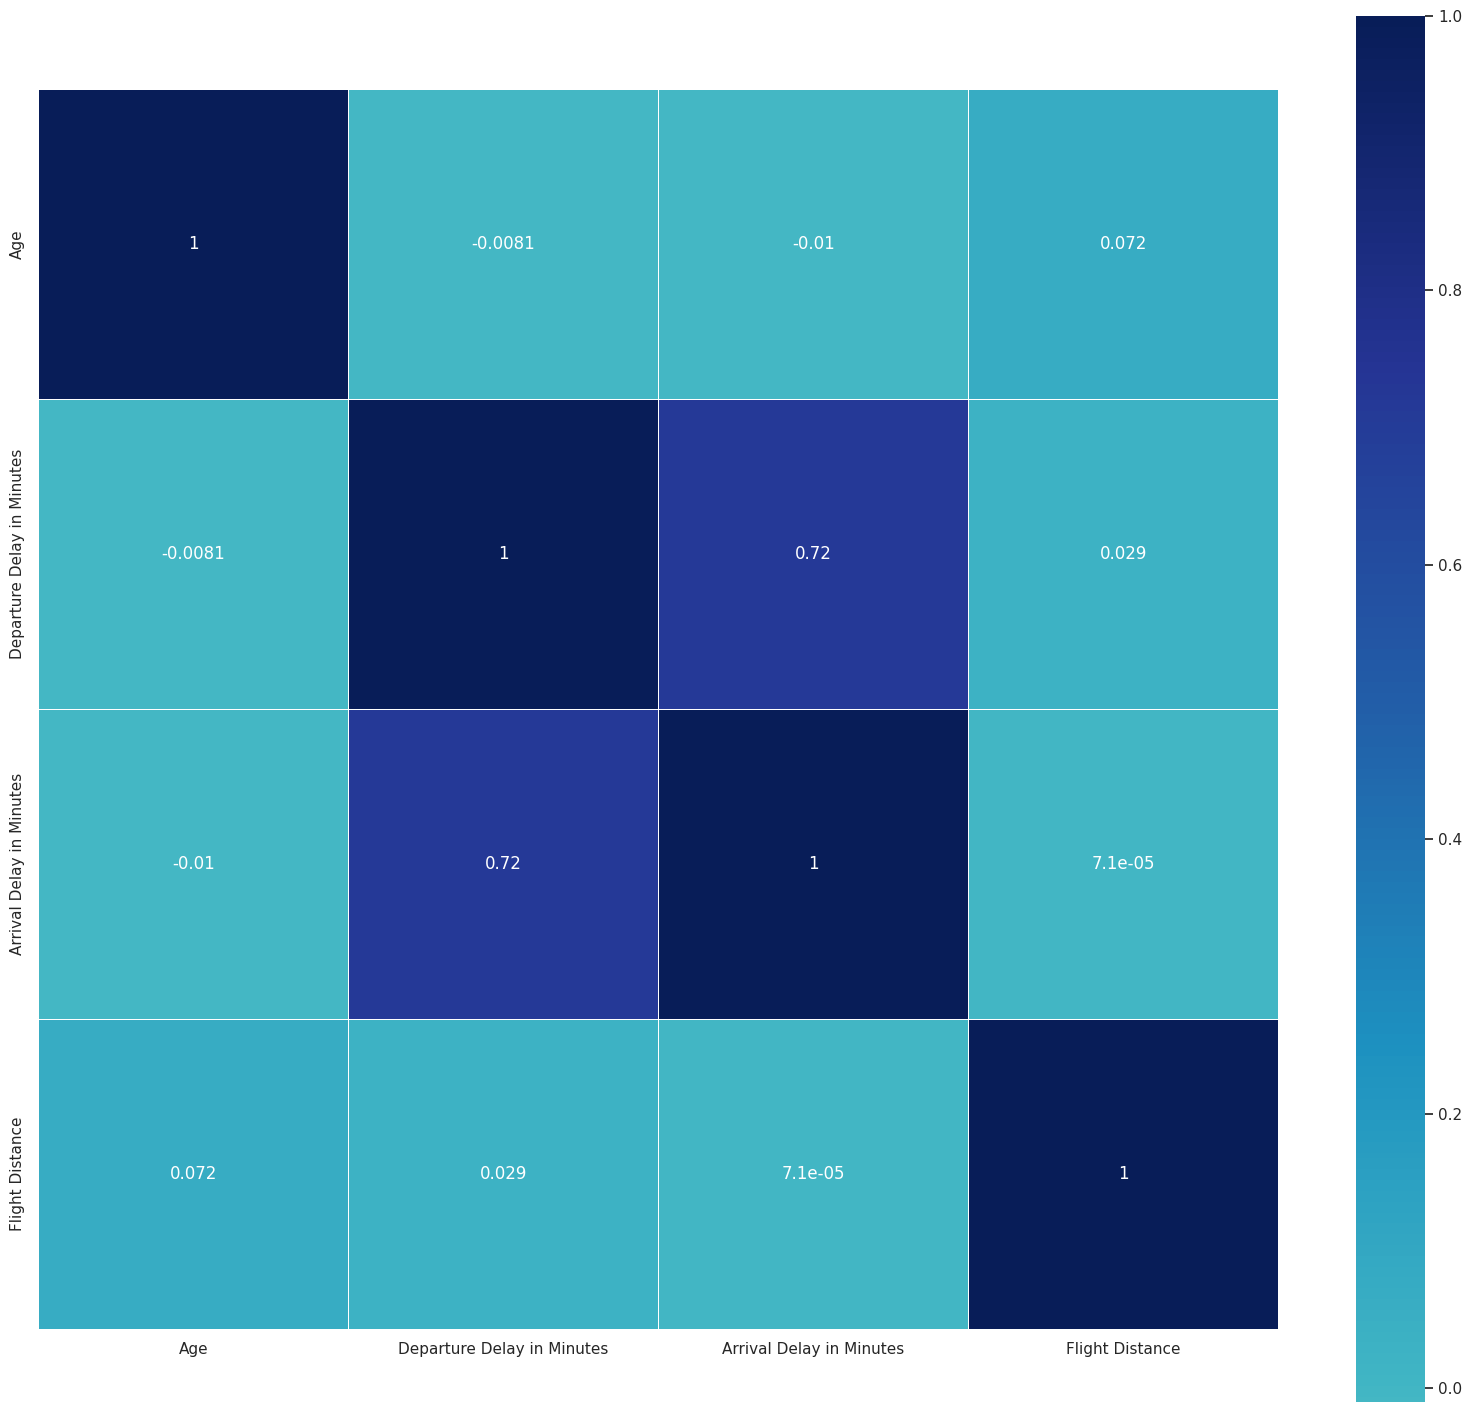

In [55]:
columns = ['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']

corr = train_df[columns].corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, cmap="YlGnBu", center=0,
           square=True, linewidths=.5)

In [56]:
corr

,Age,Departure Delay in Minutes,Arrival Delay in Minutes,Flight Distance
Age,1.000000,-0.008068,-0.010291,0.071733
Departure Delay in Minutes,-0.008068,1.000000,0.717249,0.028747
Arrival Delay in Minutes,-0.010291,0.717249,1.000000,0.000071
Flight Distance,0.071733,0.028747,0.000071,1.000000


## Categorical Variables (Chi Squared Test)

In [57]:
columns = ['Class', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'satisfaction', 'Type of Travel_Personal Travel', 'Gender_Male',
       'Customer Type_disloyal Customer']

print('Shape Before dropna: ', train_df[columns].shape)
df_corr = train_df[columns].dropna()
print('Shape After dropna: ', df_corr.shape)

cat_var_prod = list(product(columns,columns, repeat = 1))

result = []
for i in cat_var_prod:
       if i[0] != i[1]:
              result.append((i[0],i[1],list(stats.chi2_contingency(pd.crosstab(df_corr[i[0]], df_corr[i[1]])))[1]))
result

Shape Before dropna:  (76180, 19)
Shape After dropna:  (76180, 19)


[('Class', 'Inflight wifi service', 0.0),
 ('Class', 'Departure/Arrival time convenient', 0.0),
 ('Class', 'Ease of Online booking', 0.0),
 ('Class', 'Gate location', 0.0),
 ('Class', 'Food and drink', 3.5583866670023954e-183),
 ('Class', 'Online boarding', 0.0),
 ('Class', 'Seat comfort', 0.0),
 ('Class', 'Inflight entertainment', 0.0),
 ('Class', 'On-board service', 0.0),
 ('Class', 'Leg room service', 0.0),
 ('Class', 'Baggage handling', 0.0),
 ('Class', 'Checkin service', 0.0),
 ('Class', 'Inflight service', 0.0),
 ('Class', 'Cleanliness', 0.0),
 ('Class', 'satisfaction', 0.0),
 ('Class', 'Type of Travel_Personal Travel', 0.0),
 ('Class', 'Gender_Male', 9.898177106907803e-06),
 ('Class', 'Customer Type_disloyal Customer', 4.769904667727103e-249),
 ('Inflight wifi service', 'Class', 0.0),
 ('Inflight wifi service', 'Departure/Arrival time convenient', 0.0),
 ('Inflight wifi service', 'Ease of Online booking', 0.0),
 ('Inflight wifi service', 'Gate location', 0.0),
 ('Inflight wifi s

<Axes: >

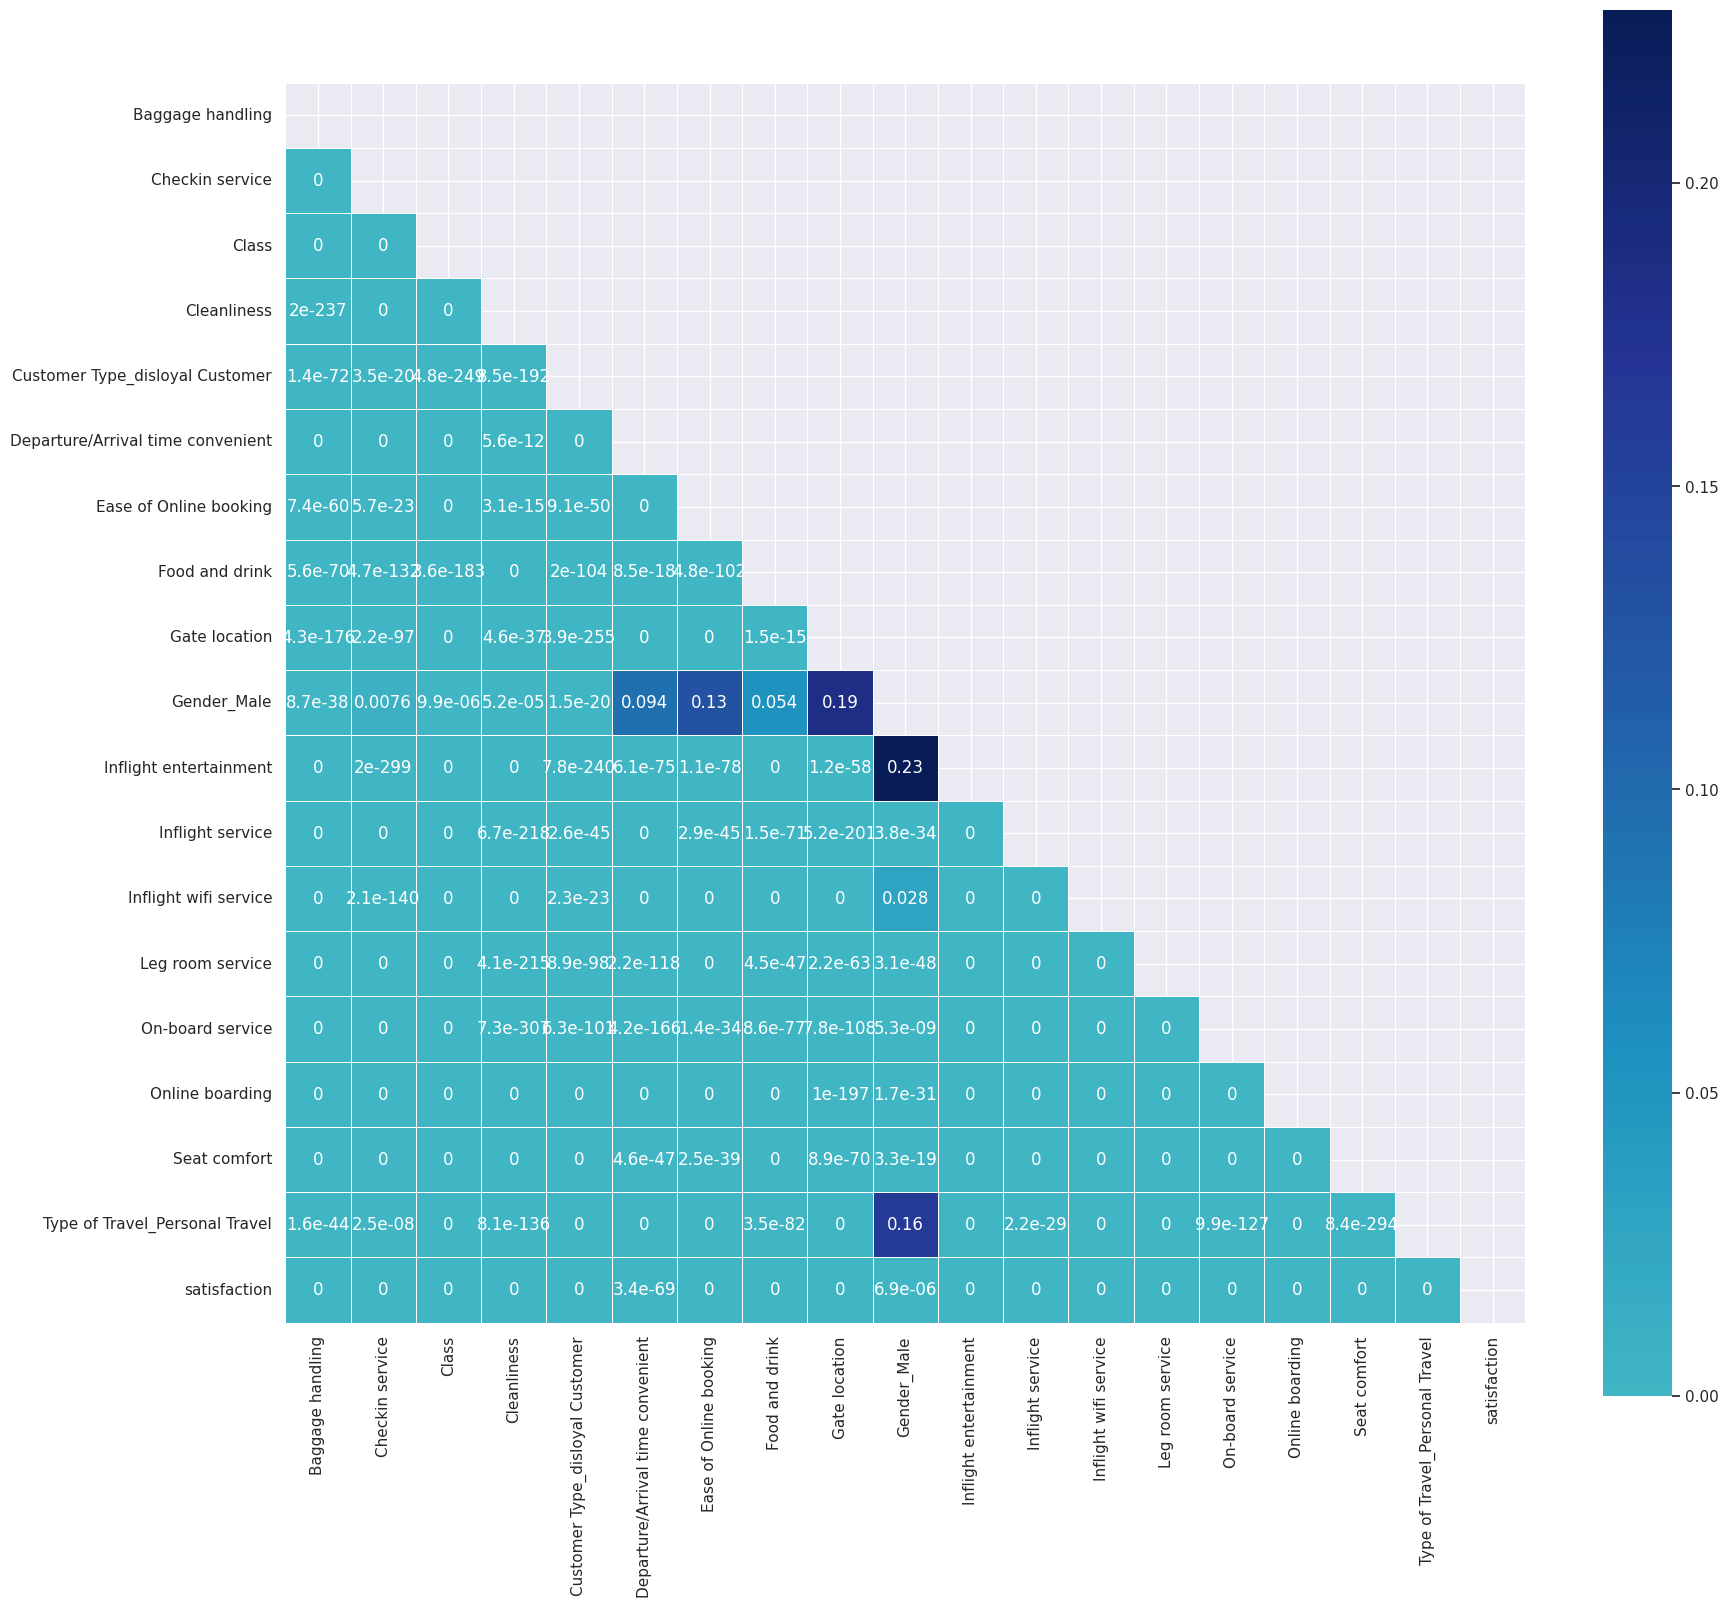

In [58]:
chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2',
                                                       'corr'])

chi_test_output = chi_test_output.pivot(index='var1', columns='var2', values='corr')
chi_test_output =  chi_test_output.rename_axis(None, axis=1)
chi_test_output =  chi_test_output.rename_axis(None, axis=0)

# Generate a mask for the upper triangle
mask = np.zeros_like(chi_test_output, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(chi_test_output, annot = True, mask=mask, cmap="YlGnBu", center=0,
           square=True, linewidths=.5)


# Binning

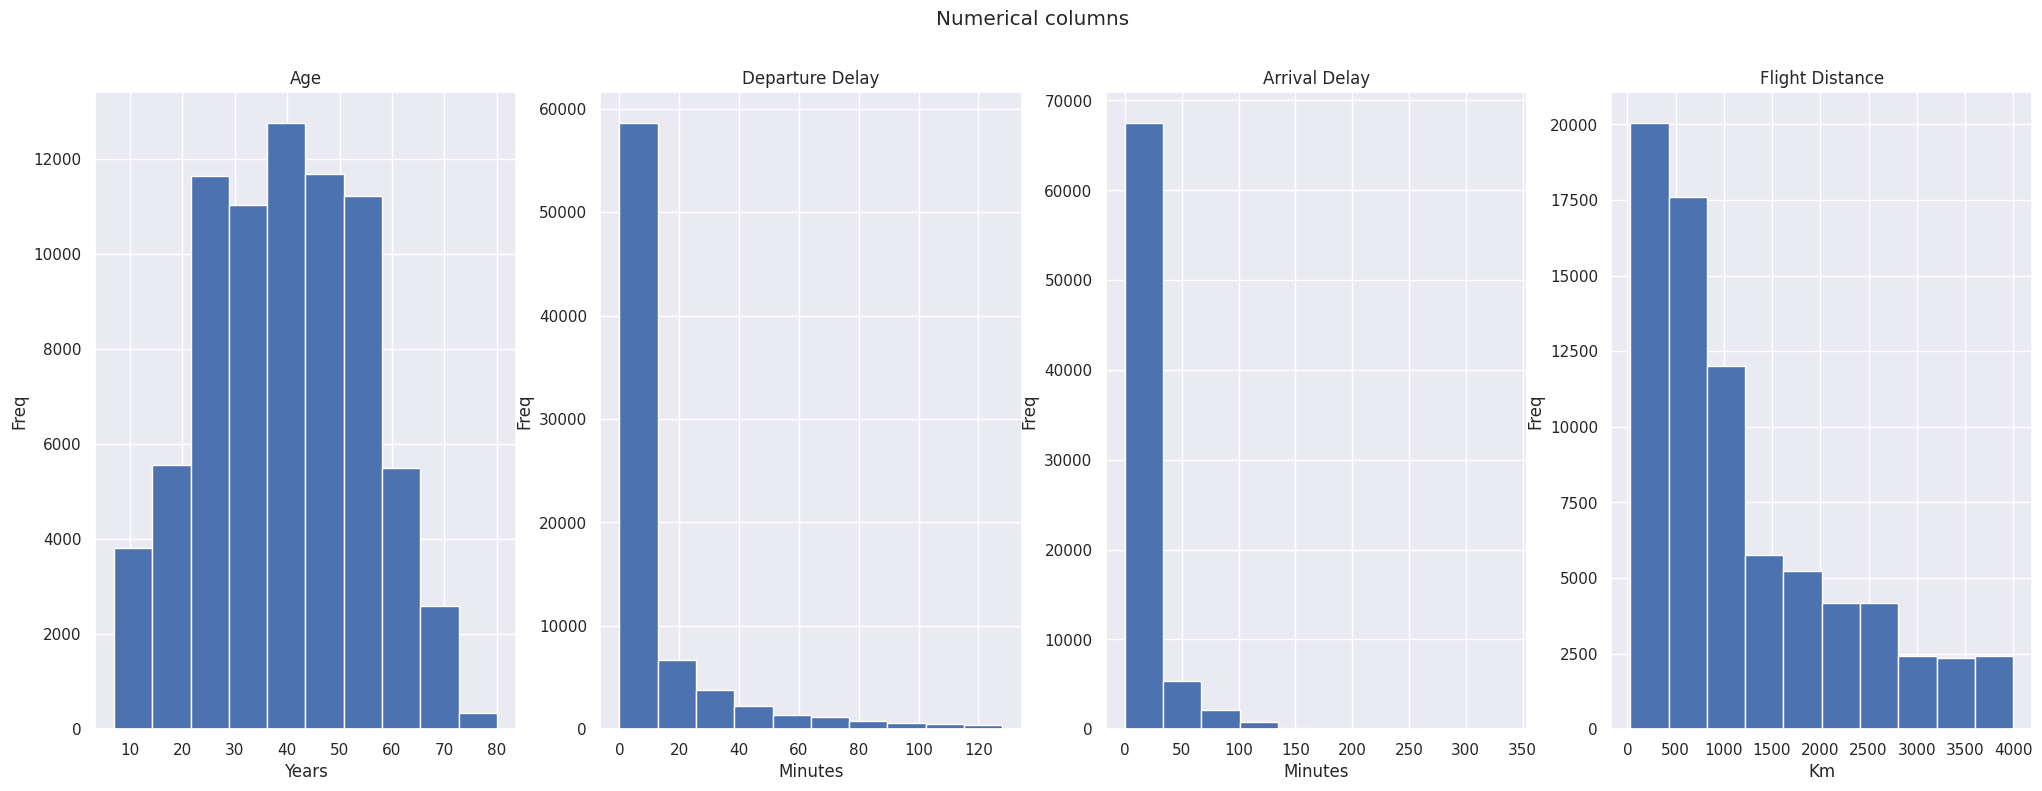

In [59]:
binning_vars = ['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

fig.set_figwidth(25)
fig.suptitle('Numerical columns')

ax1.set_title('Age')
ax1.set(xlabel='Years', ylabel='Freq')
ax1.hist(train_df['Age'])

ax2.set_title('Departure Delay')
ax2.set(xlabel='Minutes', ylabel='Freq')
ax2.hist(train_df['Departure Delay in Minutes'])

ax3.set_title('Arrival Delay')
ax3.set(xlabel='Minutes', ylabel='Freq')
ax3.hist(train_df['Arrival Delay in Minutes'])

ax4.set_title('Flight Distance')
ax4.set(xlabel='Km', ylabel='Freq')
ax4.hist(train_df['Flight Distance'])

plt.show()

In [60]:
def dist_binning(column: str):
    # 4 bins
    boundary = math.ceil((train_df[column].max()- train_df[column].min())/4)

    print(f'{column} boundary to split: ', boundary)

    bins_means = [math.ceil(train_df[(train_df[column] >= boundary*i) & (train_df[column] < boundary*(i+1))][column].mean()) for i in range(4)]
    print('Bin means: ', bins_means)

    def binnign_method(age) -> int:

        if np.isnan(age):
            return np.nan

        if age < boundary:
            return bins_means[0]

        if age < 2*boundary:
            return bins_means[1]

        if age < 3*boundary:
            return bins_means[2]

        if age < 4*boundary:
            return bins_means[3]

    print(f'{column} before binning: ', train_df[column].head(10))
    train_df[column] = train_df[column].map(binnign_method)
    validation_df[column] = validation_df[column].map(binnign_method)
    print(f'{column} After binning: ', train_df[column].head(10))


### Age

In [61]:
dist_binning(column='Age')

Age boundary to split:  19
Bin means:  [14, 29, 47, 63]
Age before binning:  0    56
1    38
2    52
3    60
4    34
5    49
6    15
7    28
8    29
9    63
Name: Age, dtype: int64
Age After binning:  0    47.0
1    47.0
2    47.0
3    63.0
4    29.0
5    47.0
6    14.0
7    29.0
8    29.0
9    63.0
Name: Age, dtype: float64


### Departure Delay

In [62]:
dist_binning(column='Departure Delay in Minutes')

Departure Delay in Minutes boundary to split:  32
Bin means:  [4, 45, 78, 111]
Departure Delay in Minutes before binning:  0    91
1     0
2     0
3     7
4     9
5    34
6     6
7     7
8     0
9     3
Name: Departure Delay in Minutes, dtype: int64
Departure Delay in Minutes After binning:  0    78.0
1     4.0
2     4.0
3     4.0
4     4.0
5    45.0
6     4.0
7     4.0
8     4.0
9     4.0
Name: Departure Delay in Minutes, dtype: float64


### Arrival Delay

In [63]:
dist_binning(column='Arrival Delay in Minutes')

Arrival Delay in Minutes boundary to split:  85
Bin means:  [9, 107, 191, 337]
Arrival Delay in Minutes before binning:  0    76.0
1     0.0
2     0.0
3    56.0
4     5.0
5    40.0
6     9.0
7     0.0
8     0.0
9    28.0
Name: Arrival Delay in Minutes, dtype: float64
Arrival Delay in Minutes After binning:  0    9.0
1    9.0
2    9.0
3    9.0
4    9.0
5    9.0
6    9.0
7    9.0
8    9.0
9    9.0
Name: Arrival Delay in Minutes, dtype: float64


### Flight Distance

In [64]:
dist_binning(column='Flight Distance')

Flight Distance boundary to split:  993
Bin means:  [496, 1427, 2441, 3479]
Flight Distance before binning:  0    1431
1    1999
2    1907
3     283
4     846
5    2475
6    1947
7    3045
8     696
9    1041
Name: Flight Distance, dtype: int64
Flight Distance After binning:  0    1427.0
1    2441.0
2    1427.0
3     496.0
4     496.0
5    2441.0
6    1427.0
7    3479.0
8     496.0
9    1427.0
Name: Flight Distance, dtype: float64


In [65]:
train_df.describe()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,75966.000000,76180.000000,76003.000000,76180.000000,76180.000000,76180.000000,76180.000000,76180.000000,76180.000000,76180.000000,76180.000000,76180.000000,76180.000000,76180.000000,76180.000000,76180.000000,76180.000000,76153.000000,75956.000000,76180.000000
mean,40.009359,1.029365,1178.838862,2.729089,3.051693,2.753584,2.973261,3.208244,3.252914,3.445511,3.361538,3.383158,3.344395,3.625742,3.305684,3.648136,3.288619,10.686933,11.417952,0.434996
std,14.045356,0.963063,948.981719,1.328943,1.527471,1.398956,1.278568,1.329089,1.349007,1.318411,1.334156,1.287920,1.319434,1.185288,1.263136,1.171905,1.311624,20.162856,15.432026,0.495760
min,14.000000,0.000000,496.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,4.000000,9.000000,0.000000
25%,29.000000,0.000000,496.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,4.000000,9.000000,0.000000
50%,47.000000,1.000000,496.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,4.000000,9.000000,0.000000
75%,47.000000,2.000000,1427.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,4.000000,9.000000,1.000000
max,63.000000,2.000000,3479.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,111.000000,337.000000,1.000000


# Missing Values

In [66]:
# sns.heatmap(train_df.isnull(), cbar=False)
print(train_df.columns[train_df.isnull().any()])
columns = train_df.columns[train_df.isnull().any()]
train_df[columns] = train_df[columns].fillna(train_df[columns].median())
print(train_df.columns[train_df.isnull().any()])

Index(['Age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes'],
      dtype='object')
Index([], dtype='object')


In [67]:
# sns.heatmap(validation_df.isnull(), cbar=False)
print(validation_df.columns[validation_df.isnull().any()])
columns = validation_df.columns[validation_df.isnull().any()]

#substituindo pela mediana do conjunto de teste
validation_df[columns] = validation_df[columns].fillna(train_df[columns].median())
validation_df.columns[validation_df.isnull().any()]

Index(['Age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes'],
      dtype='object')


Index([], dtype='object')

# Min Max Scaling

In [68]:
columns = ['Age', 'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

scaler = MinMaxScaler()
f_scaler=scaler.fit(train_df[columns])

# Train
train_df[columns] = f_scaler.transform(train_df[columns])

# Validation
validation_df[columns] = f_scaler.transform(validation_df[columns])

# OverSampling

In [69]:
def overSampling(x, y):
  ros = RandomOverSampler(
    sampling_strategy='auto',
    random_state=0,
  )
  return ros.fit_resample(x,y)

def printClassDistributionRate(y):
  print('total: ',len(y))
  print('satisfied: ', len(y[y['satisfaction'] == 1]), ' not satisfied: ', len(y[y['satisfaction'] != 1]))
  print('satisfied: {:.2f}%'.format(len(y[y['satisfaction'] == 1])/len(y) * 100), ' not satisfied: {:.2f}%'.format(len(y[y['satisfaction'] != 1])/len(y) * 100), '\n')

In [70]:
x_train_df = train_df.drop(columns='satisfaction')
y_train_df = train_df[['satisfaction']]

printClassDistributionRate(y_train_df)

x_train_df, y_train_df = overSampling(x_train_df, y_train_df )

printClassDistributionRate(y_train_df)

total:  76180
satisfied:  33138  not satisfied:  43042
satisfied: 43.50%  not satisfied: 56.50% 

total:  86084
satisfied:  43042  not satisfied:  43042
satisfied: 50.00%  not satisfied: 50.00% 



In [71]:
x_validation_df = validation_df.drop(columns='satisfaction')
y_validation_df = validation_df[['satisfaction']]

printClassDistributionRate(y_validation_df)

x_validation_df, y_validation_df = overSampling(x_validation_df, y_validation_df )

printClassDistributionRate(y_validation_df)

total:  25976
satisfied:  11256  not satisfied:  14720
satisfied: 43.33%  not satisfied: 56.67% 

total:  29440
satisfied:  14720  not satisfied:  14720
satisfied: 50.00%  not satisfied: 50.00% 



# Experimento com Modelos

In [72]:
X_train, _, y_train, _ = train_test_split(x_train_df, y_train_df, test_size=0.90, stratify=y_train_df['satisfaction'])
X_valid, _, y_valid, _ = train_test_split(x_validation_df, y_validation_df, test_size=0.50, stratify=y_validation_df['satisfaction'])


# X_train, y_train = x_train_df, y_train_df
# X_valid, y_valid = x_validation_df, y_validation_df

X_train.shape, y_train.shape

((8608, 22), (8608, 1))

In [73]:
def plot_confusion(y_true, y_pred, title):
 disp = ConfusionMatrixDisplay.from_predictions(
 y_true,
 y_pred,
 cmap=plt.cm.Blues,
 normalize=None,
 )
 disp.ax_.set_title(title)
 plt.show()

In [74]:
BATCH_SIZE = 128
EPOCHS = 20000

## MLP - Keras

In [ ]:
class MPL():
  def __init__(self, in_shape, out_shape, hidden_layers, activation, dropout, optmizer, lr, regularization, patience) -> None:
    self.model = Sequential()

    self.model.add(keras.Input(shape=in_shape))
    for layer in hidden_layers:
      self.model.add(Dense(layer, activation=activation, activity_regularizer=regularizers.L2(regularization)))
      self.model.add(Dropout(dropout))


    self.model.add(Dense(out_shape, activation=activation))

    self.model.summary()

    self.early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=0)

    self.opt = optmizer(learning_rate=lr)

  def __del__(self):
    del self.model

  def train(self, X_train, y_train, X_validation, y_validation, batch_size, epochs):
    self.model.compile(loss="sparse_categorical_crossentropy", optimizer=self.opt, metrics=['accuracy'])
    return self.model.fit(X_train, y_train, validation_data = (X_validation, y_validation), batch_size = batch_size, epochs = epochs, shuffle = True, callbacks=[self.early_stop_callback], verbose=0)

  def evaluate(self, X, y):
    loss, accuracy = self.model.evaluate(X, y)
    print('Loss:', loss)
    print('Accuracy:', accuracy)
    return loss, accuracy

  def predict(self, x):
    return self.model.predict(x)

In [ ]:
def plot_train_history(history):
  pd.DataFrame(history.history).plot()
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

PARAMETROS: F.Act.: sigmoid; Layers: [10, 5]; LR: 0.1; Dropout: 0; Reg: 0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

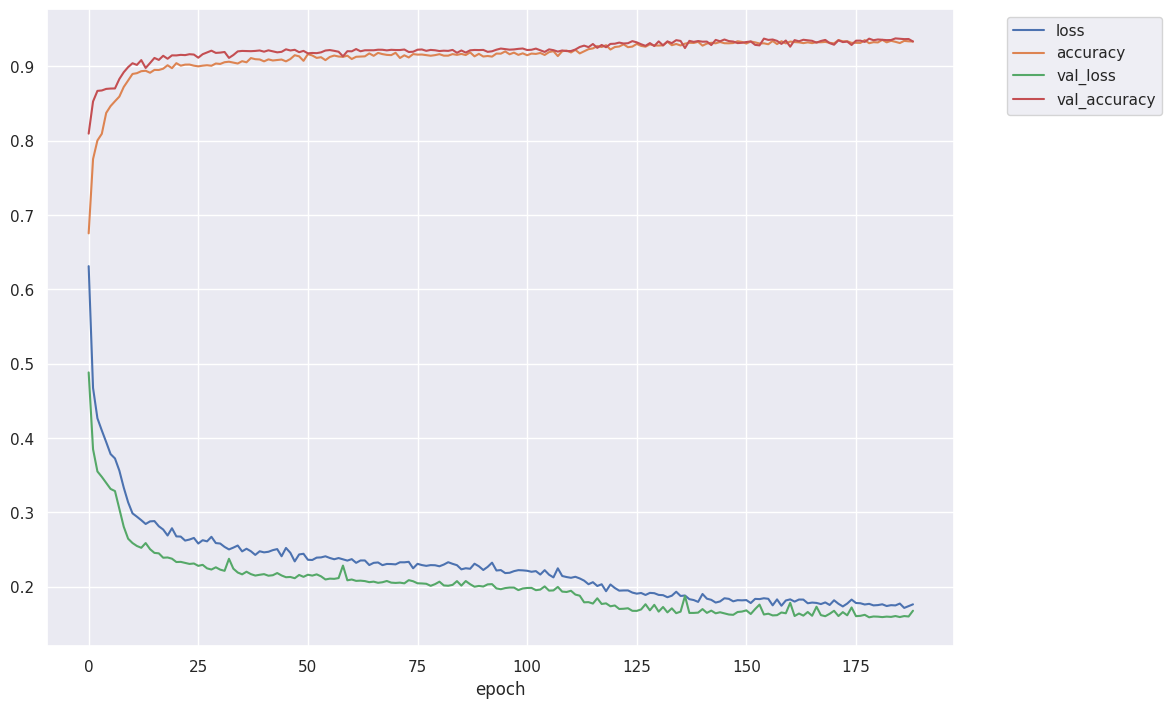

In [ ]:
def grid_search(X_t, y_t, X_v, y_v, activation_fn, hidden_layers, learning_rate, dropout, regularization):
  best_acc = 0
  best_model = None
  best_hist = None
  args = None

  for act in activation_fn:
    for hl in hidden_layers:
      for lr in learning_rate:
        for drp in dropout:
          for reg in regularization:
            print(f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}')
            tf.keras.backend.clear_session()
            model = MPL(in_shape=(22,), out_shape=2, hidden_layers=hl, activation=act, dropout=drp, optmizer=optimizers.Adam, lr=lr, regularization=reg, patience=10)
            history = model.train(X_t, y_t, X_v, y_v, batch_size=BATCH_SIZE, epochs=EPOCHS)
            loss, acc = model.evaluate(X_v, y_v)
            if acc > best_acc:
                best_acc = acc
                best_model = model
                best_hist = history
                args = f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}'
            print(f'SCORES: acc: {acc}, loss: {loss}\n')
            del model
            del history
  print(f"\n\nBest model args: {args}")
  return best_model, best_hist

X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train.values).astype('float32')
X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid.values).astype('float32')

hidden_channels = [[10, 5], [5, 10]]
actv_fns = ['sigmoid', 'relu', 'tanh','softmax']
learning_rates = [0.1, 0.01]
dropout = [0, 0.1]
regularization = [0, 0.01]

# softmax; Layers: [10, 5]; LR: 0.01; Dropout: 0; Reg: 0.01

# hidden_channels = [[10, 5]]
# actv_fns = ['softmax']
# learning_rates = [0.01]
# dropout = [0]
# regularization = [0.01]

best_model, best_hist = grid_search(X_t, y_t, X_v, y_v, actv_fns, hidden_channels, learning_rates, dropout, regularization)
plot_train_history(best_hist)

In [ ]:
best_model.evaluate(X_v, y_v)

460/460 [==============================] - 1s 2ms/step - loss: 0.1589 - accuracy: 0.9374
Loss: 0.15887874364852905
Accuracy: 0.9373641014099121


(0.15887874364852905, 0.9373641014099121)

In [ ]:
# X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train.values).astype('float32')
# X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid.values).astype('float32')

# tf.keras.backend.clear_session()
# history = best_model.train(X_t, y_t, X_v, y_v, batch_size=BATCH_SIZE, epochs=EPOCHS)

In [ ]:
# plot_train_history(history)

In [ ]:
# best_model.evaluate(X_v, y_v)

In [ ]:
# y_pred = best_model.predict(X_v)
# y_pred
# plot_confusion(y_v, y_pred, 'Best Model')

## MLP - Keras c/ Optuna

In [75]:
class MPL():
  def __init__(self, in_shape, out_shape, hidden_layers, activation, dropout, optmizer, lr, regularization, patience) -> None:
    self.model = Sequential()

    self.model.add(keras.Input(shape=in_shape))
    for layer in hidden_layers:
      self.model.add(Dense(layer, activation=activation, activity_regularizer=regularizers.L2(regularization)))
      self.model.add(Dropout(dropout))


    self.model.add(Dense(out_shape, activation=activation))

    self.model.summary()

    self.early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=0)

    self.opt = optmizer(learning_rate=lr)

  def __del__(self):
    del self.model

  def train(self, X_train, y_train, X_validation, y_validation, batch_size, epochs):
    self.model.compile(loss="sparse_categorical_crossentropy", optimizer=self.opt, metrics=['accuracy'])
    return self.model.fit(X_train, y_train, validation_data = (X_validation, y_validation), batch_size = batch_size, epochs = epochs, shuffle = True, callbacks=[self.early_stop_callback], verbose=0)

  def evaluate(self, X, y):
    loss, accuracy = self.model.evaluate(X, y)
    print('Loss:', loss)
    print('Accuracy:', accuracy)
    return loss, accuracy

  def predict(self, x):
    return self.model.predict(x)

In [76]:
def plot_train_history(history):
  pd.DataFrame(history.history).plot()
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

In [79]:
X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train.values).astype('float32')
X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid.values).astype('float32')

def objective(trial):

  hidden_channels = [[10, 5], [5, 10]]
  actv_fns = ['sigmoid', 'relu', 'tanh','softmax']
  learning_rates = [1e-2, 1e-1]
  dropout = [0, 0.1]
  regularization = [0, 1e-2]

  # softmax; Layers: [10, 5]; LR: 0.01; Dropout: 0; Reg: 0.01

  # hidden_channels = [[10, 5]]
  # actv_fns = ['softmax']
  # learning_rates = [0.01]
  # dropout = [0]
  # regularization = [0.01]

  hl = trial.suggest_categorical('Hidden Channels', hidden_channels)
  act = trial.suggest_categorical('Activation Function', actv_fns)
  lr = trial.suggest_categorical('Learning rate', learning_rates)
  drp = trial.suggest_categorical('Dropout', dropout)
  reg = trial.suggest_categorical('Regularization', regularization)

  tf.keras.backend.clear_session()
  model = MPL(in_shape=(22,), out_shape=2, hidden_layers=hl, activation=act, dropout=drp, optmizer=optimizers.legacy.Adam, lr=lr, regularization=reg, patience=10)
  history = model.train(X_t, y_t, X_v, y_v, batch_size=BATCH_SIZE, epochs=EPOCHS)
  loss, acc = model.evaluate(X_v, y_v)

  trial.set_user_attr(key="model", value=model)

  return loss

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["model"])

study = opt.create_study(direction = 'minimize')
study.optimize(objective, n_trials=100, callbacks=[callback])

best_model = study.user_attrs['best_model']

study.best_trial

# best_model, best_hist = grid_search(X_t, y_t, X_v, y_v, actv_fns, hidden_channels, learning_rates, dropout, regularization)
# plot_train_history(best_hist)

[I 2024-07-06 20:21:17,287] A new study created in memory with name: no-name-e45c476d-0845-4385-b40c-c14adea20b82


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:21:47,358] Trial 0 finished with value: 0.2569900453090668 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0.01}. Best is trial 0 with value: 0.2569900453090668.


Loss: 0.2569900453090668
Accuracy: 0.90625
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________

[I 2024-07-06 20:21:54,231] Trial 1 finished with value: 0.6931459307670593 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'relu', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 0 with value: 0.2569900453090668.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:22:07,986] Trial 2 finished with value: 0.2624693810939789 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'softmax', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 0 with value: 0.2569900453090668.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:22:23,856] Trial 3 finished with value: 0.16262945532798767 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'softmax', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 3 with value: 0.16262945532798767.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:22:29,444] Trial 4 finished with value: 0.6931459307670593 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'tanh', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 3 with value: 0.16262945532798767.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:23:12,155] Trial 5 finished with value: 0.6931459307670593 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'tanh', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 3 with value: 0.16262945532798767.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:23:55,066] Trial 6 finished with value: 0.21584171056747437 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'softmax', 'Learning rate': 0.01, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 3 with value: 0.16262945532798767.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:24:01,126] Trial 7 finished with value: 0.7376257181167603 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'tanh', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0.01}. Best is trial 3 with value: 0.16262945532798767.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:24:14,677] Trial 8 finished with value: 0.20814776420593262 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'softmax', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0.01}. Best is trial 3 with value: 0.16262945532798767.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:24:58,154] Trial 9 finished with value: 0.6931459307670593 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'tanh', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 3 with value: 0.16262945532798767.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:26:21,851] Trial 10 finished with value: 0.1566736102104187 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 10 with value: 0.1566736102104187.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:27:05,046] Trial 11 finished with value: 0.1728418469429016 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 10 with value: 0.1566736102104187.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:28:28,939] Trial 12 finished with value: 0.1652253121137619 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 10 with value: 0.1566736102104187.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:29:11,702] Trial 13 finished with value: 0.6931210160255432 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'relu', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 10 with value: 0.1566736102104187.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:29:54,491] Trial 14 finished with value: 0.1563831865787506 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'softmax', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 14 with value: 0.1563831865787506.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:30:19,591] Trial 15 finished with value: 0.1586075872182846 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 14 with value: 0.1563831865787506.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:30:36,176] Trial 16 finished with value: 0.1613776981830597 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'softmax', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 14 with value: 0.1563831865787506.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:32:00,643] Trial 17 finished with value: 0.1572321057319641 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 14 with value: 0.1563831865787506.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:32:08,265] Trial 18 finished with value: 0.6931459307670593 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'relu', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 14 with value: 0.1563831865787506.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:32:51,668] Trial 19 finished with value: 0.15698203444480896 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 14 with value: 0.1563831865787506.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:33:37,622] Trial 20 finished with value: 0.17065447568893433 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'softmax', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 14 with value: 0.1563831865787506.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:34:20,289] Trial 21 finished with value: 0.15598957240581512 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 21 with value: 0.15598957240581512.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:34:59,242] Trial 22 finished with value: 0.16638128459453583 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 21 with value: 0.15598957240581512.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:35:33,893] Trial 23 finished with value: 0.17185468971729279 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 21 with value: 0.15598957240581512.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:36:16,664] Trial 24 finished with value: 0.15784890949726105 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 21 with value: 0.15598957240581512.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:37:08,533] Trial 25 finished with value: 0.1517571359872818 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 25 with value: 0.1517571359872818.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:37:31,559] Trial 26 finished with value: 0.15752367675304413 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'softmax', 'Learning rate': 0.01, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 25 with value: 0.1517571359872818.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:37:39,280] Trial 27 finished with value: 0.523549497127533 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'relu', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 25 with value: 0.1517571359872818.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:38:30,303] Trial 28 finished with value: 0.1434473842382431 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 28 with value: 0.1434473842382431.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:38:52,593] Trial 29 finished with value: 0.19755099713802338 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0.01}. Best is trial 28 with value: 0.1434473842382431.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:39:35,293] Trial 30 finished with value: 0.17125976085662842 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 28 with value: 0.1434473842382431.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:40:17,768] Trial 31 finished with value: 0.15915732085704803 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 28 with value: 0.1434473842382431.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:41:00,842] Trial 32 finished with value: 0.22311973571777344 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 28 with value: 0.1434473842382431.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:41:38,997] Trial 33 finished with value: 0.15152834355831146 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 28 with value: 0.1434473842382431.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:42:01,244] Trial 34 finished with value: 0.14985603094100952 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 28 with value: 0.1434473842382431.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:42:23,743] Trial 35 finished with value: 0.15190042555332184 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 28 with value: 0.1434473842382431.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:42:46,203] Trial 36 finished with value: 0.1624571830034256 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 28 with value: 0.1434473842382431.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:43:07,541] Trial 37 finished with value: 0.13870017230510712 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:43:12,339] Trial 38 finished with value: 0.6931459307670593 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'tanh', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:43:55,935] Trial 39 finished with value: 0.6931461095809937 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'relu', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:44:18,685] Trial 40 finished with value: 0.27155086398124695 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:44:37,865] Trial 41 finished with value: 0.14370305836200714 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:44:49,016] Trial 42 finished with value: 0.1783614605665207 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:45:04,780] Trial 43 finished with value: 0.1680305153131485 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:45:12,407] Trial 44 finished with value: 0.6931459307670593 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'tanh', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Loss: 0.6931459307670593
Accuracy: 0.5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________________________________

[I 2024-07-06 20:45:34,631] Trial 45 finished with value: 0.14820550382137299 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:45:57,060] Trial 46 finished with value: 0.2532326281070709 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:46:19,292] Trial 47 finished with value: 0.15557332336902618 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:46:27,078] Trial 48 finished with value: 0.6931459307670593 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'tanh', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:46:42,309] Trial 49 finished with value: 0.16173328459262848 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:46:56,356] Trial 50 finished with value: 0.17919319868087769 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:47:08,966] Trial 51 finished with value: 0.16701649129390717 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Loss: 0.16701649129390717
Accuracy: 0.929959237575531
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
______________________________________

[I 2024-07-06 20:47:20,982] Trial 52 finished with value: 0.15712527930736542 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:47:31,552] Trial 53 finished with value: 0.15743888914585114 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:47:51,897] Trial 54 finished with value: 0.15001283586025238 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:47:58,819] Trial 55 finished with value: 0.6931459307670593 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'relu', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:48:11,915] Trial 56 finished with value: 0.15292924642562866 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:48:34,702] Trial 57 finished with value: 0.16604097187519073 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:48:47,590] Trial 58 finished with value: 0.15653745830059052 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'softmax', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:49:01,355] Trial 59 finished with value: 0.14691326022148132 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:49:14,054] Trial 60 finished with value: 0.15350496768951416 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Loss: 0.15350496768951416
Accuracy: 0.9345787763595581
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________________

[I 2024-07-06 20:49:41,055] Trial 61 finished with value: 0.1697341799736023 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:50:00,813] Trial 62 finished with value: 0.1477295309305191 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:50:23,096] Trial 63 finished with value: 0.1521967202425003 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:50:39,644] Trial 64 finished with value: 0.15161794424057007 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:50:51,630] Trial 65 finished with value: 0.1557995229959488 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:50:58,618] Trial 66 finished with value: 0.5865243673324585 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'tanh', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:51:05,506] Trial 67 finished with value: 0.6931459307670593 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'relu', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:51:29,302] Trial 68 finished with value: 0.1595659703016281 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Loss: 0.1595659703016281
Accuracy: 0.9343070387840271
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
______________________________________

[I 2024-07-06 20:51:45,276] Trial 69 finished with value: 0.1944391429424286 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'softmax', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:52:08,344] Trial 70 finished with value: 0.15860731899738312 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:52:31,256] Trial 71 finished with value: 0.1429857462644577 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:52:48,158] Trial 72 finished with value: 0.14353559911251068 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:53:10,613] Trial 73 finished with value: 0.24865107238292694 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:53:27,896] Trial 74 finished with value: 0.15549331903457642 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:53:38,555] Trial 75 finished with value: 0.1536104679107666 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:54:01,421] Trial 76 finished with value: 0.15970782935619354 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:54:24,272] Trial 77 finished with value: 0.14388024806976318 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Loss: 0.14388024806976318
Accuracy: 0.9377037882804871
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________________

[I 2024-07-06 20:54:46,619] Trial 78 finished with value: 0.1504388004541397 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:55:09,160] Trial 79 finished with value: 0.14886508882045746 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:55:21,496] Trial 80 finished with value: 0.14907650649547577 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:55:37,829] Trial 81 finished with value: 0.15228156745433807 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:55:53,150] Trial 82 finished with value: 0.1518038660287857 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:56:08,546] Trial 83 finished with value: 0.15332604944705963 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:56:31,428] Trial 84 finished with value: 0.15041661262512207 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:57:14,157] Trial 85 finished with value: 0.16975250840187073 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:57:21,110] Trial 86 finished with value: 0.6931459307670593 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'tanh', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:57:26,533] Trial 87 finished with value: 0.6931459307670593 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'relu', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:57:49,413] Trial 88 finished with value: 0.1638694554567337 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'softmax', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:58:40,613] Trial 89 finished with value: 0.1444578319787979 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 20:59:12,557] Trial 90 finished with value: 0.18933716416358948 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 20:59:55,605] Trial 91 finished with value: 0.15269716084003448 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 21:01:20,059] Trial 92 finished with value: 0.1593754142522812 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 21:02:12,887] Trial 93 finished with value: 0.1561717391014099 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 21:02:51,044] Trial 94 finished with value: 0.1489429622888565 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 21:04:15,010] Trial 95 finished with value: 0.22038298845291138 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 21:04:33,201] Trial 96 finished with value: 0.15019363164901733 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 21:04:47,877] Trial 97 finished with value: 0.14329466223716736 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 21:05:04,428] Trial 98 finished with value: 0.16602258384227753 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.1, 'Dropout': 0, 'Regularization': 0.01}. Best is trial 37 with value: 0.13870017230510712.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=================

[I 2024-07-06 21:05:45,206] Trial 99 finished with value: 0.15464124083518982 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'sigmoid', 'Learning rate': 0.01, 'Dropout': 0.1, 'Regularization': 0}. Best is trial 37 with value: 0.13870017230510712.


In [82]:
study.best_params

{'Hidden Channels': [10, 5],
 'Activation Function': 'sigmoid',
 'Learning rate': 0.1,
 'Dropout': 0,
 'Regularization': 0}

In [80]:
best_model.evaluate(X_v, y_v)

460/460 [==============================] - 1s 1ms/step - loss: 0.1387 - accuracy: 0.9402
Loss: 0.13870017230510712
Accuracy: 0.9402173757553101


(0.13870017230510712, 0.9402173757553101)

In [ ]:
# X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train.values).astype('float32')
# X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid.values).astype('float32')

# tf.keras.backend.clear_session()
# history = best_model.train(X_t, y_t, X_v, y_v, batch_size=BATCH_SIZE, epochs=EPOCHS)

In [ ]:
# plot_train_history(history)

In [ ]:
# best_model.evaluate(X_v, y_v)

In [ ]:
# y_pred = best_model.predict(X_v)
# y_pred
# plot_confusion(y_v, y_pred, 'Best Model')

## MLP - Torch

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
def train(model, optimizer, loss_fn, train_dl, valid_dl, epochs, plot_loss = False):
  best_loss = np.infty

  model = model.to(device)
  best_model = model
  model.train()
  train_losses = []
  valid_losses = []

  for epoch in range(epochs):

    acc_loss = []

    for X, y in iter(train_dl):


      X = X.to(device)
      y = y.to(device)

      y_hat = model(X).softmax(dim=1)

      loss = loss_fn(y_hat, y)

      del X, y

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      acc_loss.append(loss.detach().cpu())

    train_losses.append(np.mean(acc_loss))

    acc_loss = []

    for X, y in valid_dl:
      X = X.to(device)
      y = y.to(device)
      y_hat = model(X).softmax(dim=1)
      loss = loss_fn(y_hat, y)
      acc_loss.append(loss.detach().cpu())

    valid_losses.append(np.mean(acc_loss))

    if valid_losses[-1] < best_loss:
      best_loss = valid_losses[-1]
      best_model = model

    if best_loss < 0.05:
      return best_model

    if epoch % 250 == 0:
      print(f'Epoch: {epoch}/{epochs}', f'Best loss: {best_loss}')

    if plot_loss:
      clear_output(wait=True)

      plt.grid()

      plt.plot(train_losses, linestyle = '--', color = "orange", label = 'Train Losses')
      plt.plot(valid_losses, linestyle = '--', color = "blue", label = 'Validation Losses')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')

      plt.legend()

      plt.show()

  return best_model




In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

def aux(train_dl, valid_dl, activation_fn, hidden_layers, lr, dropout, reg):

  clf = MLP(in_channels=22, hidden_channels=hidden_layers, activation_layer=activation_fn, dropout=dropout)
  print(clf)
  clf.train()

  optimizer = optim.SGD(clf.parameters(), lr=lr, weight_decay=reg)
  loss_fn = torch.nn.CrossEntropyLoss()

  best_model = train(clf, optimizer, loss_fn, train_dl, valid_dl, epochs = 20000)

  best_model.eval()

  predicted_train = best_model(X_train_tensor.float().to(device)).argmax(dim=1).cpu().detach()
  predicted_valid = best_model(X_valid_tensor.float().to(device)).argmax(dim=1).cpu().detach()

  return best_model, (accuracy_score(y_valid_tensor, predicted_valid), recall_score(y_valid_tensor, predicted_valid, average='weighted'), precision_score(y_valid_tensor, predicted_valid, average='weighted'), f1_score(y_valid_tensor, predicted_valid, average='weighted'))

In [ ]:
def grid_search(train_dl, valid_dl, activation_fn, hidden_layers, learning_rate, dropout, regularization):
  best_acc = 0
  best_model = None
  args = None

  for act in activation_fn:
    for hl in hidden_layers:
      for lr in learning_rate:
        for drp in dropout:
          for reg in regularization:
            print(f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}')
            model, scores = aux(train_dl, valid_dl, act, hl, lr, drp, reg)
            acc, recall, precision, f1 = scores
            if acc > best_acc:
                best_acc = acc
                best_model = model
                args = f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}'
            print(f'SCORES: acc: {acc}; recall: {recall}; precision: {precision}; f1:{f1}\n')
  print(f"\n\nBest model args: {args}")
  return best_model

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

In [ ]:
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.int64).ravel())

X_valid_tensor = torch.tensor(X_valid.values.astype(np.float32))
y_valid_tensor = torch.tensor(y_valid.values.astype(np.int64).ravel())

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size = 256, shuffle = True, num_workers=2)
valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size = 256, shuffle = True, num_workers=2)

hidden_channels = [[5], [5, 10]]
actv_fns = [torch.nn.ReLU, torch.nn.Sigmoid, torch.nn.Tanh]
learning_rates = [0.1, 0.01]
dropout = [0,0.1]
regularization = [0, 0.01]

#best_model = grid_search(train_dl, valid_dl, actv_fns, hidden_channels, learning_rates, dropout, regularization)


# RF